In [1]:
import math, time, copy, os, sys
from dataclasses import dataclass
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split, TensorDataset
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import torch
import numpy as np

# Determinism
SEED = 42
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", DEVICE)

Device: cuda


In [2]:
class MnistDataloader(object):
    def __init__(self, training_images_filepath, training_labels_filepath,
                 test_images_filepath, test_labels_filepath):
        self.training_images_filepath = training_images_filepath
        self.training_labels_filepath = training_labels_filepath
        self.test_images_filepath = test_images_filepath
        self.test_labels_filepath = test_labels_filepath
    
    def read_images_labels(self, images_filepath, labels_filepath):        
        from array import array
        import struct
        
        with open(labels_filepath, 'rb') as file:
            magic, size = struct.unpack(">II", file.read(8))
            assert magic == 2049, f'Expected 2049, got {magic}'
            labels = np.frombuffer(file.read(), dtype=np.uint8)
        
        with open(images_filepath, 'rb') as file:
            magic, size, rows, cols = struct.unpack(">IIII", file.read(16))
            assert magic == 2051, f'Expected 2051, got {magic}'
            images = np.frombuffer(file.read(), dtype=np.uint8).reshape(size, rows, cols)
        
        return images, labels
            
    def load_data(self):
        x_train, y_train = self.read_images_labels(self.training_images_filepath, self.training_labels_filepath)
        x_test, y_test   = self.read_images_labels(self.test_images_filepath, self.test_labels_filepath)
        return (x_train, y_train), (x_test, y_test)

In [3]:
# ==== FIXED HYPERPARAMETERS (DO NOT CHANGE) ====
EPOCHS = 20
BATCH_SIZE = 256

# Optimizer hyperparams
HP = {
    "momentum": {"lr": 0.05, "momentum": 0.9},
    "amsgrad": {"lr": 0.03, "beta1": 0.9, "beta2": 0.999, "eps": 1e-8},
    "rmsprop": {"lr": 1e-3, "alpha": 0.99, "eps": 1e-8},
    "adam": {"lr": 1e-3, "beta1": 0.9, "beta2": 0.999, "eps": 1e-8},
}

In [4]:
loader = MnistDataloader(
    "/kaggle/input/mnist-dataset/train-images-idx3-ubyte/train-images-idx3-ubyte",
    "/kaggle/input/mnist-dataset/train-labels-idx1-ubyte/train-labels-idx1-ubyte",
    "/kaggle/input/mnist-dataset/t10k-images-idx3-ubyte/t10k-images-idx3-ubyte",
    "/kaggle/input/mnist-dataset/t10k-labels-idx1-ubyte/t10k-labels-idx1-ubyte"
)

(x_train, y_train), (x_test, y_test) = loader.load_data()

# Convert to torch tensors
x_train = torch.tensor(x_train, dtype=torch.float32).unsqueeze(1) / 255.0
y_train = torch.tensor(y_train, dtype=torch.long)
x_test  = torch.tensor(x_test, dtype=torch.float32).unsqueeze(1) / 255.0
y_test  = torch.tensor(y_test, dtype=torch.long)

# Full train dataset
full_train = TensorDataset(x_train, y_train)

# Make a train/val split (55k / 5k)
train_set, val_set = random_split(full_train, [55000, 5000])

# Test dataset
test_set = TensorDataset(x_test, y_test)

# Dataloaders
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(val_set,   batch_size=BATCH_SIZE, shuffle=False)
test_loader  = DataLoader(test_set,  batch_size=BATCH_SIZE, shuffle=False)

print(len(train_set), len(val_set), len(test_set))


55000 5000 10000


In [5]:
# ==== MODEL (fixed small CNN) ====
class MNISTNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=0)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=0)
        self.pool = nn.MaxPool2d(2, 2)
        self.drop1 = nn.Dropout(0.25)
        self.drop2 = nn.Dropout(0.5)
        # For 28x28 -> after two 3x3 convs (no pad), size 24x24 -> pool -> 12x12 -> 64ch -> 64*12*12 = 9216
        self.fc1 = nn.Linear(64 * 12 * 12, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = self.drop1(x)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.drop2(x)
        x = self.fc2(x)
        return x

def accuracy(logits, targets):
    preds = logits.argmax(dim=1)
    return (preds == targets).float().mean().item()

model = MNISTNet().to(DEVICE)

In [6]:
class BaseOptimizer:
    def __init__(self, params):
        # Expect a list of parameter tensors with .data and .grad
        self.params = [p for p in params if p.requires_grad]
        self.state = {}  # dict[param] = per-param buffers
        

    @torch.no_grad()
    def zero_grad(self):
        for p in self.params:
            if p.grad is not None:
                p.grad.zero_()

    def step(self):
        raise NotImplementedError

In [7]:
class MomentumSGD(BaseOptimizer):
    def __init__(self, params, lr=0.05, momentum=0.9):
        super().__init__(params)
        self.lr = lr
        self.momentum = momentum
        for p in self.params:
            self.state[p] = torch.zeros_like(p) 

    @torch.no_grad()
    def step(self):
        for p in self.params:
            if p.grad is not None:
                # in place add and mul, memory and speed efficient
                # p.grad just stores gradient, doesn't compute. So updating p does not change it
                # all variables just pointers not copy
                grad = p.grad
                state = self.state[p]
                state.mul_(self.momentum).add_(grad, alpha = self.lr)
                p.add_(-state)
        


In [19]:
class AMSGrad(BaseOptimizer):
    def __init__(self, params, lr=0.03, beta1=0.9, beta2=0.999, eps=1e-8):
        super().__init__(params)
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.eps = eps
        for p in self.params:
            self.state[p] = {
                'm': torch.zeros_like(p),
                'v': torch.zeros_like(p),
                'v_max': torch.zeros_like(p),
            }
    @torch.no_grad()
    def step(self):
        for p in self.params:
            if p.grad is not None:
                # all of these are pointers not copies, speciality of pytorch
                grad = p.grad
                state = self.state[p]
                m, v, v_max = state['m'], state['v'], state['v_max']
                m.mul_(self.beta1).add_(grad, alpha =1 - self.beta1)
                v.mul_(self.beta2).add_(grad * grad, alpha =1 - self.beta2)
                # v_max = torch.max(v_max, v) this is wrong since it isn't in place update
                state['v_max'] = torch.max(v_max,v)
                denom = torch.sqrt(state['v_max']).add_(self.eps)
                p.addcdiv_(m, denom, value=-self.lr)

In [9]:
class RMSProp(BaseOptimizer):
    def __init__(self, params, lr=1e-3, alpha=0.99, eps=1e-8):
        super().__init__(params)
        self.lr = lr
        self.alpha = alpha
        self.eps = eps
        for p in self.params:
            self.state[p] = torch.zeros_like(p)
    @torch.no_grad()
    def step(self):
        for p in self.params:
            if p.grad is not None:
                grad = p.grad
                state = self.state[p]
                state.mul_(self.alpha).add_(grad*grad, alpha = 1 - self.alpha)
                denom = torch.sqrt(state).add_(self.eps)
                p.addcdiv_(grad, denom, value=-self.lr)
                

In [10]:
class Adam(BaseOptimizer):
    def __init__(self, params, lr=1e-3, beta1=0.9, beta2=0.999, eps=1e-8):
        super().__init__(params)
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.eps = eps
        for p in self.params:
            self.state[p] = {
                'step': 0,
                'm': torch.zeros_like(p),
                'v': torch.zeros_like(p),
            }
    @torch.no_grad()
    def step(self):
        for p in self.params:
            if p.grad is not None:
                grad = p.grad
                state = self.state[p]
                state['step'] += 1
                step, m, v = state['step'], state['m'], state['v']
                m.mul_(self.beta1).add_(grad, alpha = 1 - self.beta1)
                v.mul_(self.beta2).add_(grad * grad, alpha = 1 - self.beta2)
                m_hat = m/(1 - self.beta1**step)
                v_hat = v/(1 - self.beta2**step)
                denom = torch.sqrt(v_hat).add_(self.eps)
                p.addcdiv_(m_hat, denom, value = -self.lr)
                

In [11]:
def run_epoch(model, loader, optimizer=None):
    is_train = optimizer is not None
    model.train(is_train)
    total_loss, total_acc, total_count = 0.0, 0.0, 0

    for x, y in loader:
        x, y = x.to(DEVICE), y.to(DEVICE)
        if is_train:
            optimizer.zero_grad()
        logits = model(x)
        loss = F.cross_entropy(logits, y)
        if is_train:
            loss.backward()
            optimizer.step()

        bs = y.size(0)
        total_loss += loss.item() * bs
        total_acc += (logits.argmax(1) == y).float().sum().item()
        total_count += bs

    return total_loss / total_count, total_acc / total_count

def train_one_optimizer(opt_name, OptClass, hp):
    model = MNISTNet().to(DEVICE)
    opt = OptClass(model.parameters(), **hp)
    history = {"time": [], "train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}

    t0 = time.time()
    for epoch in range(1, EPOCHS + 1):
        tr_loss, tr_acc = run_epoch(model, train_loader, opt)
        va_loss, va_acc = run_epoch(model, val_loader, None)

        t = time.time() - t0
        history["time"].append(t)
        history["train_loss"].append(tr_loss); history["train_acc"].append(tr_acc)
        history["val_loss"].append(va_loss);   history["val_acc"].append(va_acc)

        print(f"[{opt_name}] epoch {epoch}/{EPOCHS}  "
              f"train_loss={tr_loss:.4f} acc={tr_acc:.4f}  "
              f"val_loss={va_loss:.4f} acc={va_acc:.4f}  time={t:.1f}s")

    return model, history

In [20]:
optimizers = {
    "Momentum": (MomentumSGD, HP["momentum"]),
    "AMSGrad": (AMSGrad, HP["amsgrad"]),
    "RMSProp": (RMSProp, HP["rmsprop"]),
    "Adam": (Adam, HP["adam"]),
}

all_hist = {}
for name, (OptClass, hp) in optimizers.items():
    _, hist = train_one_optimizer(name, OptClass, hp)
    all_hist[name] = hist

[Momentum] epoch 1/20  train_loss=0.4652 acc=0.8517  val_loss=0.1010 acc=0.9684  time=3.0s
[Momentum] epoch 2/20  train_loss=0.1345 acc=0.9605  val_loss=0.0680 acc=0.9812  time=6.0s
[Momentum] epoch 3/20  train_loss=0.0924 acc=0.9725  val_loss=0.0649 acc=0.9822  time=9.1s
[Momentum] epoch 4/20  train_loss=0.0758 acc=0.9773  val_loss=0.0528 acc=0.9852  time=12.1s
[Momentum] epoch 5/20  train_loss=0.0626 acc=0.9813  val_loss=0.0465 acc=0.9870  time=15.1s
[Momentum] epoch 6/20  train_loss=0.0542 acc=0.9833  val_loss=0.0408 acc=0.9888  time=18.1s
[Momentum] epoch 7/20  train_loss=0.0510 acc=0.9843  val_loss=0.0412 acc=0.9874  time=21.1s
[Momentum] epoch 8/20  train_loss=0.0440 acc=0.9864  val_loss=0.0398 acc=0.9888  time=24.1s
[Momentum] epoch 9/20  train_loss=0.0418 acc=0.9871  val_loss=0.0365 acc=0.9894  time=27.0s
[Momentum] epoch 10/20  train_loss=0.0384 acc=0.9884  val_loss=0.0415 acc=0.9884  time=30.2s
[Momentum] epoch 11/20  train_loss=0.0358 acc=0.9888  val_loss=0.0465 acc=0.9870  

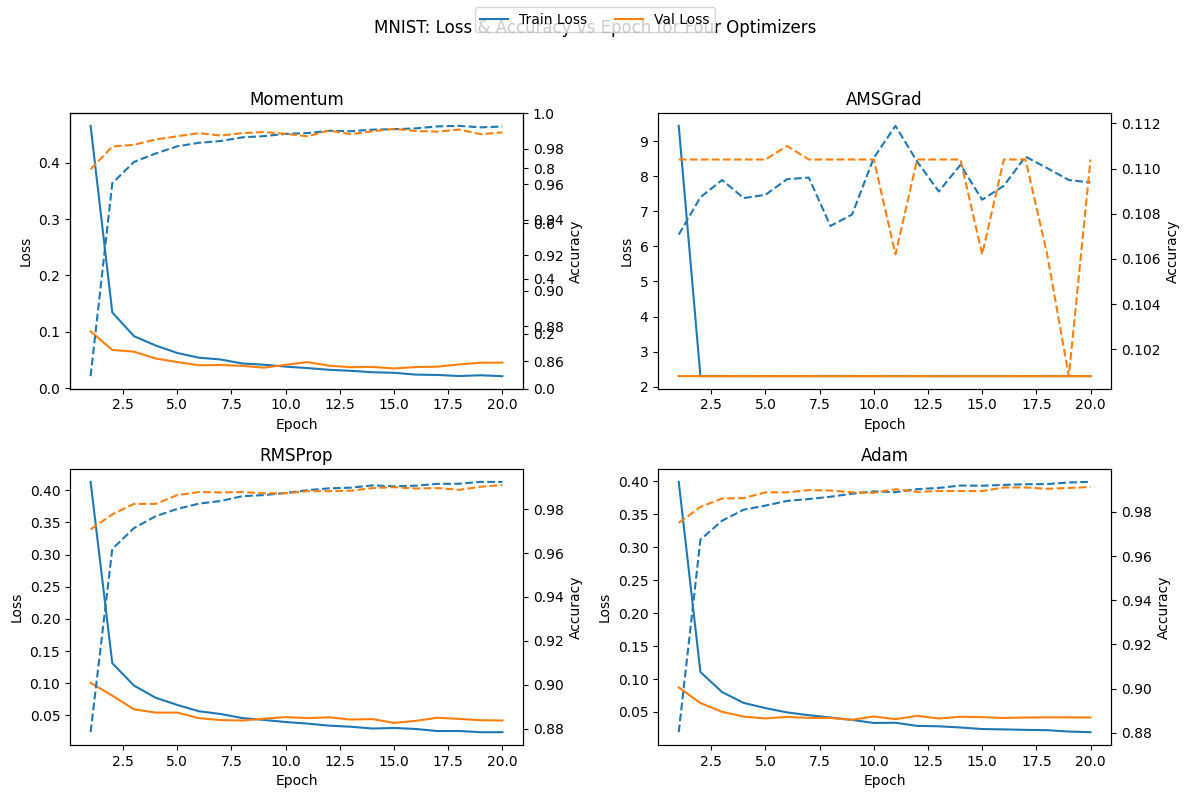

In [26]:
# === Plot: one page with 2x2 subplots; each subplot shows Train/Val Loss (left y) and Accuracy (right y) vs Epoch ===
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
order = ["Momentum", "AMSGrad", "RMSProp", "Adam"]

for ax, name in zip(axes.ravel(), order):
    hist = all_hist[name]
    epochs = list(range(1, len(hist["train_loss"]) + 1))
    # Left y: Loss
    ax.plot(epochs, hist["train_loss"], label="Train Loss")
    ax.plot(epochs, hist["val_loss"], label="Val Loss")
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Loss")
    ax.set_title(name)

    # Right y: Accuracy
    ax2 = ax.twinx()
    ax2.plot(epochs, hist["train_acc"], linestyle="--", label="Train Acc")
    ax2.plot(epochs, hist["val_acc"], linestyle="--", label="Val Acc")
    ax2.set_ylabel("Accuracy")

# Single legend outside
handles1, labels1 = axes[0,0].get_legend_handles_labels()
handles2, labels2 = axes[0,0].twinx().get_legend_handles_labels()
fig.legend(handles1 + handles2, labels1 + labels2, loc="upper center", ncol=4)
fig.suptitle("MNIST: Loss & Accuracy vs Epoch for Four Optimizers", y=0.98)
fig.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

In [27]:
# === Page-2 Summary Helper ===
import pandas as pd
rows = []
for name in ["Momentum", "AMSGrad", "RMSProp", "Adam"]:
    h = all_hist[name]
    rows.append({
        "optimizer": name,
        "final_train_acc": h["train_acc"][-1],
        "final_val_acc": h["val_acc"][-1],
        "final_train_loss": h["train_loss"][-1],
        "final_val_loss": h["val_loss"][-1],
        "total_time_s": h["time"][-1],
    })
summary_df = pd.DataFrame(rows)
summary_df

,optimizer,final_train_acc,final_val_acc,final_train_loss,final_val_loss,total_time_s
0,Momentum,0.992509,0.9892,0.021410,0.045531,59.962471
1,AMSGrad,0.109382,0.1104,2.302454,2.302296,60.646849
2,RMSProp,0.992364,0.9910,0.023611,0.041793,60.173396
3,Adam,0.993545,0.9912,0.019234,0.041594,61.191595
